# ABOUT


Datascientest's Datascientist continuous bootcamp - cohorte Mars2022 -  AeroBOT project

**Tutor**

* Alban THUET

**Authors:**

* Hélène ASSIR
* Hichem HADJI  
* [Ioannis STASINOPOULOS](https://www.linkedin.com/in/ioannis-stasinopoulos/)

</br>

---
</br>

**Version History**

Version | Date       | Author(s)  | Modification
--------|----------- | ---------  | --------------------------
X.X     | XX/XX/2022 | A.B        | modif
1.1     | 04/07/2022 | I.S, H.A.  | Anomaly one-hot encoding
1.0     | 30/06/2022 | I.S, H.A.  | Document creation

This notebook can be executed entirely. 

It

* mounts the GDrive of our AeroBot project @gmail account.

* loads the data from the `train_data_final.pkl` file (cf. `0_test_set_creator_DO_NOT_MODIFY_20220630.ipynb`) under a pandas DataFrame named `df`, which contains `97417` entries and 96 columns.
These data do not contain any more UAS-related entries.

* Performs Feature Engineering: one-hot-encoding of Anomaly using a naive approache, looking directly for the root label into the multiple modalities string of Anomaly
* A comparison of 2 approaches (Naive vs Regex, more complex) was performed, but, with very limited discrepancies between the 2 approaches, we favored the naive one (see : ATTEMPT_1_main_DO_NOT_MODIFY_20220704_Anomaly_ReGex.ipynb).  

Further processing of the data should be perfomed on this dataframe, after having **copied a version of the present notebook**.

# IMPORT PACKAGES


settings for  full / patial Narrative display. Helene?


In [1]:
#######################
# Import packages
#######################
import numpy as np
import seaborn as sns
import math # for math.pi etc.
import time # time code execution

#######################
# Pandas
#######################
import pandas as pd
# Set pandas settings to show all data when using .head(), .columns etc.
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option("display.colheader_justify","left") # left-justify the print output of pandas

### Display full columnwidth
# Set pandas settings to display full text columns
#pd.options.display.max_colwidth = None
# Restore pandas settings to display standard colwidth
pd.reset_option('display.max_colwidth')

import itertools # Pour créer des iterateurs

# Package to show the progression of pandas operations
from tqdm import tqdm
# from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
# simply use .progress_apply() instead of .apply() on your pd.DataFram

######################
# PLOTTING
######################
import matplotlib.pyplot as plt
%matplotlib inline
# Define global plot parameters for better readability and consistency among plots
# A complete list of the rcParams keys can be retrieved via plt.rcParams.keys() function
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 23
plt.rcParams['xtick.labelsize'] = 23
plt.rcParams['ytick.labelsize'] = 23
plt.rc('legend', fontsize=23)    # legend fontsize

# BOKEH 
from bokeh.plotting import figure # Importation de la classe figure qui permet de créer un graphique bokeh.
from bokeh.io import  push_notebook, output_notebook, show
output_notebook() # permet d'afficher tous les futurs graphiques dans l'output d'une cellule jupyter. Si cette instruction n'est pas lancée, la figure s'affichera dans un nouvel onglet.
from bokeh.models import ColumnDataSource
from bokeh.transform import dodge
from bokeh.models.tools import HoverTool

#####################
# NLP 
#####################
import re # for Regular Expression handling
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') # WordNet lemmatizer
nltk.download('omw-1.4') # necessary for WordNet lemmatizer
from nltk.tokenize import word_tokenize # Usual tokenizer
from nltk.tokenize import TweetTokenizer # Special tokenizer;  "we'll", "didn't", etc. are considered as one word
from sklearn.feature_extraction.text import CountVectorizer # Vectorization
from nltk.corpus import stopwords # Import stopwords from nltk.corpus
from nltk.stem.snowball import EnglishStemmer

###############################
# ML preprocessing and models
###############################
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble # random forest
from sklearn.svm import SVC

# EVALUATION tools from sklearn
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, multilabel_confusion_matrix, average_precision_score, precision_recall_curve, PrecisionRecallDisplay

###############################
# Deep Learning
###############################
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras import callbacks


###############################
# Other
###############################
import pickle as pkl # Saving data externally

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# LOAD FUNCTIONS

Functions common to several sections of this code (we should actually put them in a separate file and load them from there)

In [2]:
def plot_train_history(training_history, metric, anomaly_name):
  """
  Generete plots to monitor the train process
  Inputs: 
  - 'training_history'; use training_history = model.train(...)
  - 'metric' to plot; string e.g. 'accuracy', 'loss'
  - 'anomaly_name' e.g. 'Anomaly_Conflict'. This is used for the plot title
  """
  fig = plt.figure(figsize = (10,4))
  #plt.title(f"{anomaly_name} train history - {metric.upper()}", fontsize = 20)
  train_acc = training_history.history[metric]
  val_acc = training_history.history['val_' + metric] # e.g. 'val_accuracy'

  plt.plot(train_acc, label = f'Training {metric}')
  plt.plot(val_acc, label = f'Validation {metric}')
  plt.xlabel('epochs')
  plt.ylabel(f'{metric}')
  plt.legend()
  plt.show();

# LOAD DATA

## Mount GDrive

In [3]:
#@title
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive/')

#check your present working directory 
%pwd

Mounted at /content/drive/


'/content'

In [4]:
#@title
# move to the transformed data location (you can create a deeper structure, if needed, e.g. to save a trained model):
%cd /content/drive/MyDrive/data/transformed/

/content/drive/MyDrive/data/transformed


In [5]:
#@title
!ls # list the content of the pwd

#!ls "/content/drive/MyDrive/Data_Science/Formations/DataScienceTest/projet/AeroBot/" # list contect of a speficic folder

 complaints-2022-08-05_13_55.csv
'Copy of Qualified abbreviations_20220718.xlsx.gsheet'
'Data Dictionnary.xlsx'
 data_for_BERT_multilabel_20220805.pkl
 model.png
 model_results
 Narrative_PP_stemmed_24072022_TRAIN.pkl
 Narrative_Raw_Stemmed_24072022_TRAIN.pkl
 Narrative_RegEx_subst_21072022_TRAIN.pkl
'Qualified abbreviations_20220707_test.csv'
'Qualified abbreviations_20220708.csv'
'Qualified abbreviations_20220718.csv'
'Qualified abbreviations_20220718_Google_sheet.gsheet'
 test_data_final.pkl
 train_data_final.pkl


## Load data from .pkl file


In [6]:
#@title
# Load the TRAIN data (97417 entries)
# Do not touch the TEST data until the end of the project!
# or the curse of the greek gods will fall upon you!

%cd /content/drive/MyDrive/data/transformed/
with open("train_data_final.pkl", "rb") as f:
    loaded_data = pkl.load(f)

df = loaded_data[0]
print("\nA Dataframe with", len(df), "entries has been loaded")

/content/drive/MyDrive/data/transformed

A Dataframe with 97417 entries has been loaded


# NARRATIVE ENGINEERING

### Load the pre-processed Narrative data 

See the notebook that performs the substitutions

In [7]:
# Load the file Narrative_PP_stemmed_21072022_TRAIN.pkl
%cd /content/drive/MyDrive/data/transformed/
with open("Narrative_PP_stemmed_24072022_TRAIN.pkl", "rb") as f:
    loaded_narr = pkl.load(f)

df['Narrative_PP_stemmed'] = loaded_narr[0]
print("Data loaded")

/content/drive/MyDrive/data/transformed
Data loaded


In [8]:
# Load the file Narrative_PP_stemmed_21072022_TRAIN.pkl
%cd /content/drive/MyDrive/data/transformed/
with open("Narrative_Raw_Stemmed_24072022_TRAIN.pkl", "rb") as f:
    loaded_narr = pkl.load(f)

df['Narrative_Raw_Stemmed'] = loaded_narr[0]
print("Data loaded")

/content/drive/MyDrive/data/transformed
Data loaded


In [9]:
df.loc[1715282]['Narrative']

"I am writing this report to bring attention to the second departure frequency out of MDW last night. It is a safety issue to give us two frequency changes below 3;000 feet on departure out of MDW.We were in a heavy [aircraft] doing a full power; flaps 25; bleeds off takeoff off of 22L. These takeoffs are known to have very high climb rates; so the intermediate level-off of 3;000 feet approaches fast. At 1;000 feet; we're instructed to contact Departure on 128.2. Simultaneously; I switch frequencies and retract flaps as commanded by the pilot flying. Upon checking in with 128.2; he instructs us to climb and maintain 4;000 feet and subsequently contact 126.62. I dial in 4;000 feet and continue to retract flaps while monitoring a level-off from a climb rate of over 2;000 FPM. At this point; my head turns down to the radio to dial the new Departure frequency in. I check in and they tell us to climb and maintain 12;000 feet. I dial in 12;000 feet; confirm it; reset the autobrake and gear l

In [10]:
df.loc[1715282]['Narrative_PP_stemmed'][:20]

['write',
 'report',
 'bring',
 'attent',
 'second',
 'departur',
 'frequenc',
 'mdw',
 'last',
 'night',
 'safeti',
 'issu',
 'give',
 'us',
 'two',
 'frequenc',
 'chang',
 '3',
 '000',
 'feet']

In [11]:
df.loc[1715282]['Narrative_Raw_Stemmed'][:20]

['write',
 'report',
 'bring',
 'attent',
 'second',
 'departur',
 'frequenc',
 'mdw',
 'last',
 'night',
 'safeti',
 'issu',
 'give',
 'us',
 'two',
 'frequenc',
 'chang',
 '3',
 '000',
 'feet']

# TARGET FEATURE ENGINEERING

## Anomaly

This section 

*   drops the entries with NaN in 'Anomaly'
*   creates and adds to the DataFrame 'df' a one-hot column for each Anomaly root label

Root labels are as defined in the ASRS coding form.pdf

We use a naive approach using string parsing 

### Drop the NaNs in Anomaly

In [12]:
# Drop Anomaly NaN's
print(f"We have {len(df[df['Anomaly'].isna()])} entries where 'Anomaly' == NaN. We drop these entries")

df = df.dropna(axis = 0, how = 'any', subset = ['Anomaly'])
print(f"Current length of our DataFrame: {len(df)}")

We have 431 entries where 'Anomaly' == NaN. We drop these entries
Current length of our DataFrame: 96986


### One-hot encode Anomaly root labels

In [13]:
# Root label (source = ASRS coding forms)
Anomaly_RootLabels=['Aircraft Equipment',
                    'Airspace Violation',
                    'ATC Issue',
                    'Flight Deck / Cabin / Aircraft Event',
                    'Conflict',
                    'Deviation - Altitude',
                    'Deviation - Speed',
                    'Deviation - Track / Heading',
                    'Deviation / Discrepancy - Procedural',
                    'Ground Excursion',
                    'Ground Incursion',
                    'Ground Event / Encounter',
                    'Inflight Event / Encounter',
                    'No Specific Anomaly Occurred']

#### Naive one-hot encoding

In [14]:
# Create a column in the df corresponding to each Anomaly root label 'anomaly_rl'
Anomaly_RootLabels_columns = []
for anomaly_rl in Anomaly_RootLabels:
    col='Anomaly_' + anomaly_rl
    Anomaly_RootLabels_columns.append(col)
    # Fill the columns in a one-hot-encoding logic
    df[col] = df['Anomaly'].astype('str').apply(lambda x: 1 if (anomaly_rl in x)  else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [15]:
for anomaly_rl in Anomaly_RootLabels:
    col='Anomaly_'+anomaly_rl
    print('\n',col,'\n',df[col].value_counts())


 Anomaly_Aircraft Equipment 
 0    59054
1    37932
Name: Anomaly_Aircraft Equipment, dtype: int64

 Anomaly_Airspace Violation 
 0    92989
1     3997
Name: Anomaly_Airspace Violation, dtype: int64

 Anomaly_ATC Issue 
 0    81232
1    15754
Name: Anomaly_ATC Issue, dtype: int64

 Anomaly_Flight Deck / Cabin / Aircraft Event 
 0    89839
1     7147
Name: Anomaly_Flight Deck / Cabin / Aircraft Event, dtype: int64

 Anomaly_Conflict 
 0    79622
1    17364
Name: Anomaly_Conflict, dtype: int64

 Anomaly_Deviation - Altitude 
 0    88110
1     8876
Name: Anomaly_Deviation - Altitude, dtype: int64

 Anomaly_Deviation - Speed 
 0    94398
1     2588
Name: Anomaly_Deviation - Speed, dtype: int64

 Anomaly_Deviation - Track / Heading 
 0    88707
1     8279
Name: Anomaly_Deviation - Track / Heading, dtype: int64

 Anomaly_Deviation / Discrepancy - Procedural 
 1    58337
0    38649
Name: Anomaly_Deviation / Discrepancy - Procedural, dtype: int64

 Anomaly_Ground Excursion 
 0    94829
1     

In [16]:
# Plots
# # Parsing de la colonne 'Anomaly' et top 200 des modalités selon le 1/0 encoding
# for anomaly_rl in Anomaly_RootLabels:
#     col='Anomaly_'+anomaly_rl
    
#     title_plot=col +' : ' + str(sum(df[col]))+' entries of our DF'
#     Anomaly=df[df[col]==1]['Anomaly'].str.split('; ', expand=True).stack().reset_index(drop=True)
#     fig, ax = plt.subplots(figsize=(15,30))
#     sns.countplot(y=Anomaly, order=Anomaly.value_counts().iloc[:50].index,color='green').set(title=title_plot);

#     title_plot='NO '+col +' : ' + str(len(df)-sum(df[col]))+' entries of our DF'
#     Anomaly=df[df[col]==0]['Anomaly'].str.split('; ', expand=True).stack().reset_index(drop=True)
#     fig, ax = plt.subplots(figsize=(15,30))
#     sns.countplot(y=Anomaly, order=Anomaly.value_counts().iloc[:50].index,color='red').set(title=title_plot);

# Padding ratio

Some statistical considerations concerning narrative length (measured in # of tokens) vs. pad length.


Usefull for WordEmbedding algorithms

In [17]:
# Examine typical narrative length to get an idea about the padding / truncating step
df['Narrative_PP_stemmed_len'] = df['Narrative_PP_stemmed'].apply(lambda x: len(x))
df['Narrative_PP_stemmed_len'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


count    96986.000000
mean       143.628379
std        106.181102
min          1.000000
25%         72.000000
50%        117.000000
75%        185.000000
max       1317.000000
Name: Narrative_PP_stemmed_len, dtype: float64

Positive: narrative is longer than maxlen; there is no padding

Negative: narrative is shorter than maxlen; we have padding.

the more negative the ratio, the more padding there is. It cannot get more negative than -1.0



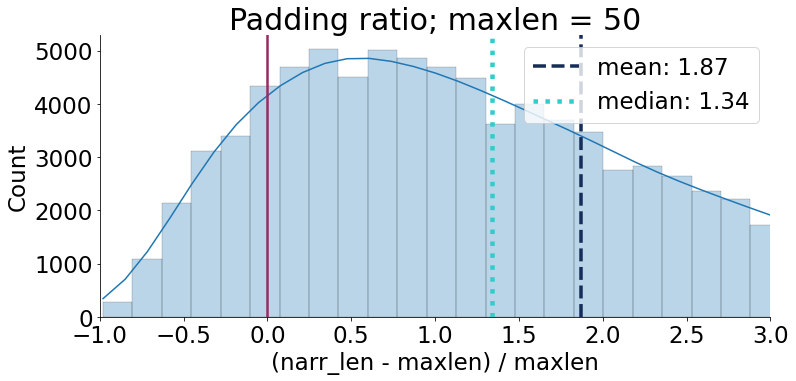

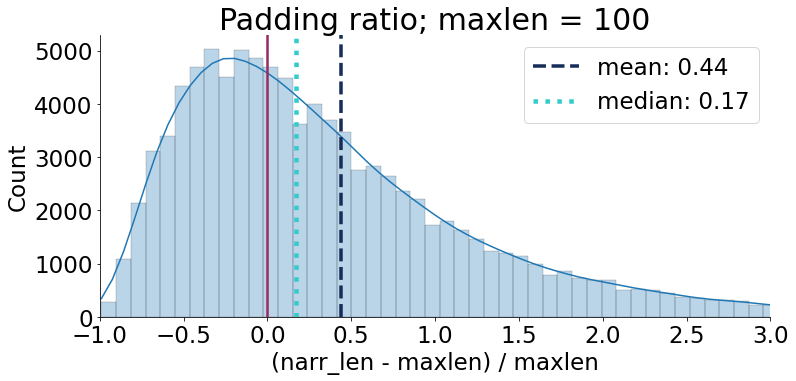

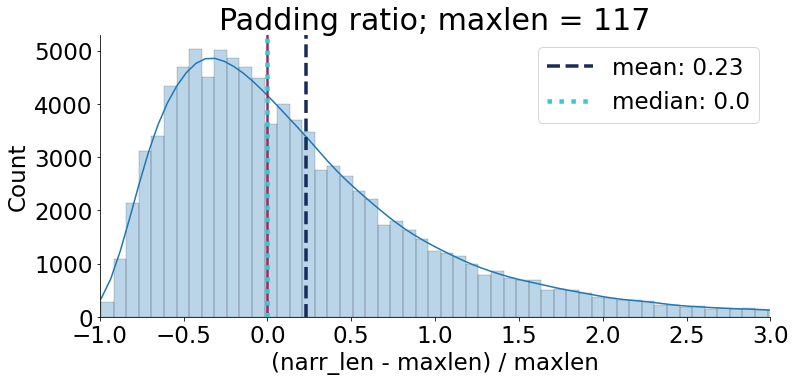

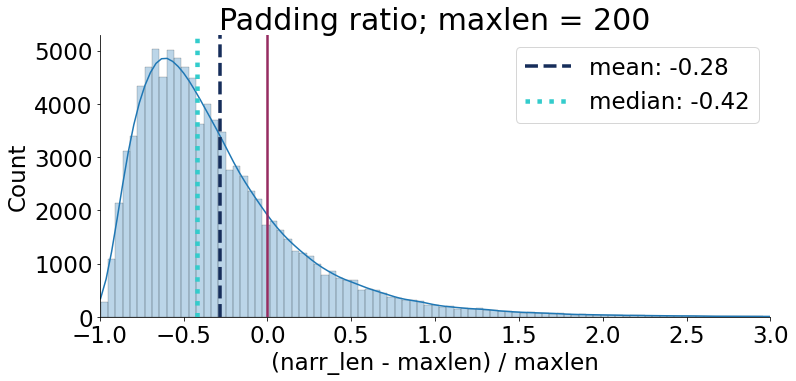

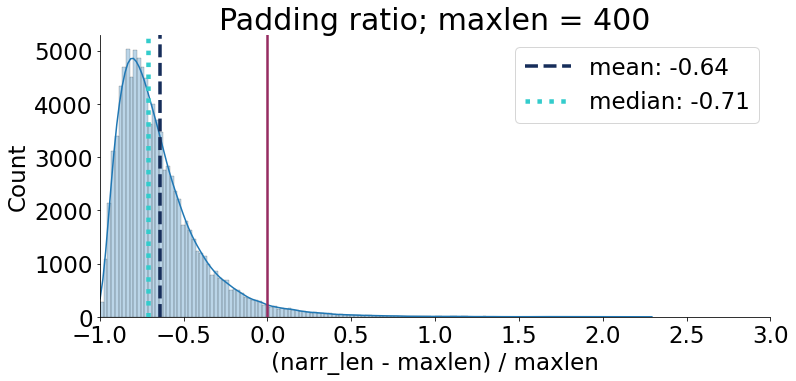

In [18]:
maxlen = 200 # length of the text vector (in words). Will ignore narrative content beyond this limit

# Plot histograms
print("Positive: narrative is longer than maxlen; there is no padding\n")
print("Negative: narrative is shorter than maxlen; we have padding.\n")
print("the more negative the ratio, the more padding there is. It cannot get more negative than -1.0\n")

for maxlen in [50, 100, 117, 200, 400]:
  pad_ratio = df['Narrative_PP_stemmed_len'].apply(lambda x: (x - maxlen) / maxlen)

  sns.displot(pad_ratio, bins = 150, kde = True, alpha  = 0.3)
  plt.xlim([-1,3])
  plt.gcf().set_size_inches(15, 5)

  # Plot mean, median as vertical lines
  mean = np.round(pad_ratio.mean(),2)
  median = np.round(pad_ratio.median(),2)
  plt.axvline(x = 0, color = '#962c61', ls='-', lw = 2.5)
  plt.axvline(x = mean, color = '#162d5a', ls='--', lw = 3.5, label = f'mean: {mean}')
  plt.axvline(x = median, color = '#33cccc', ls='dotted', lw = 4.5, label = f'median: {median}')

  plt.xlabel('(narr_len - maxlen) / maxlen')
  plt.title(f'Padding ratio; maxlen = {maxlen}')
  plt.legend();

# One vs. all Word Embedding - loop over Anomalies

## Train

In [19]:
# Join all tokens into a single string
df['Narrative_PP_stemmed_str'] = df['Narrative_PP_stemmed'].apply(lambda token_list: ' '.join(entry for entry in token_list))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
len(df['Narrative_PP_stemmed_str'].iloc[0])

1146

In [21]:
def word_embedding_clf(data, target, maxlen, num_words, N_emb): 
  """
  Perform binary classification using WordEmbedding

  Inputs:
  - data as pd.Series, narrative strings, e.g. df['Narrative_PP_stemmed_str']
  - target as pd.Series, e.g. df['Anomaly_Conflict']
  - maxlen (int) : length of the text vector (in words). Will ignore narrative content beyond this limit
  - num_words (int): desired vocab size; only the most common words are kept
  - N_emb (int) = 200: Dimension of embedding (# columns of the embedding matrix)
    # reducing this from 200 to 100 improved the f1-score of '1' from 0.85 to 0.87 !
    # reducing to 50 did not improve the f1 further


  Returns:
  - training history
  - 'metrics': pd.Dataframe containing the classification report content
  """ 

  # Time the function execution
  start_time = time.time()
  anomaly_name = target.name
  print(7*'-', f"Execution started for label '{anomaly_name}' ...", 7*'-')

  # One-hot encode target
  target = to_categorical(target) 
  # Train-test split  
  X_text_train, X_text_test, y_train, y_test = train_test_split(data, target, 
                                                      test_size= 0.2,
                                                      random_state = 12) 

  ###############################
  # TOKENIZE
  from tensorflow.keras.preprocessing.text import Tokenizer

  tokenizer = Tokenizer(num_words = num_words, # only the most common words are kept
                        oov_token = 'OOV'
                        ) 
  tokenizer.fit_on_texts(X_text_train) # Updates internal vocabulary based on a list of texts

  # Save the dictionary of correspondence between words and indices
  word2idx = tokenizer.word_index
  # Save the dictionary of correspondence between indices and words
  idx2word = tokenizer.index_word
  # Save the vocab size
  vocab_size = tokenizer.num_words  
  print('Tokenization completed.')
  print(f'Vocabulary size: {vocab_size} (user-defined)\n')
  example_OOV = word2idx['OOV']
  print(f"Example: index of 'OOV': {example_OOV} (Out-Of-Vocabulary label; user-defined)")
  example_aircraft = word2idx['aircraft']
  print(f"Example: index of 'aircraft': {example_aircraft}\n")
  print(30*"-")

  ###############################
  # VECTORIZE NARRATIVES
  # Map each text into a sequence of integers (word indices)
  # We use the vocab obtained from training on the X_text_train data to vectorize both the train and test data
  # Transform every review into a sequence of integers (indices of the vocab)
  X_train = tokenizer.texts_to_sequences(X_text_train)
  X_test = tokenizer.texts_to_sequences(X_text_test)
  print('Vectorization completed.')
  rnd_idx = np.random.randint(len(X_train), size = 2)
  for idx in rnd_idx:
    print(f'Random examples of entries in X_train:\n {X_train[idx]}')
    print(f'Length: {len(X_train[idx])}\n')
  print(30*"-")

  # Pad & truncate train and test sequences (texts transformed in numeric sequences) to make them of the same length
  X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, # Liste des textes transformés en index
                                                          maxlen = maxlen, # Nombre maximal de mots dans un texte. See length analysis above
                                                          padding = 'post', # pad either before or after each sequence
                                                          truncating = 'post', # truncate either before or after each sequence
                                                          value=0.0) # with what to pad
  # if maxlen is not provided, uses the length of the longest sequence in the list.
  X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen = maxlen, padding = 'post', truncating= 'post')
  print('Sequence padding / truncating completed.\n')
  print(f'Each entry in X_train has length: {maxlen} (user-defined)\n')
  
  for idx in rnd_idx:
    print(f"Entries in X_train now look like this (observe the presence of '1', corresponding to 'OOV'):\n\n {X_train[idx]}\n")
  print(30*"-")  

  ###############################
  # BUILD THE MODEL
  tf.keras.backend.clear_session()
  # Keras starts with a blank state at each iteration and memory consumption is constant over time.
  
  model = Sequential(name = "Word_Embedding_model") # does not accept spaces
  model.add(Embedding(input_dim = vocab_size, output_dim = N_emb)) # The embedding matrix is a *trainable* parameter
  model.add(GlobalAveragePooling1D()) # no parameters to tune; it's an advantage of GlobalAveragePooling1D
  # Use global average pooling blocks as an alternative to a Flatten() layer 

  model.add(Dense(units = 32, activation = 'relu'))
  model.add(Dropout(rate = 0.3)) # prevents overfitting
  model.add(Dense(units = 2, activation = 'sigmoid')) # 2 units, because BINARY classification problem
  # 'sigmoid' activation because binary classification
  print(model.summary())

  ###############################   
  # Define CALLBACKS
  TON = callbacks.TerminateOnNaN() # Callback that terminates training when a NaN loss is encountered

  early_stopping = callbacks.EarlyStopping(monitor = 'binary_accuracy', # 'binary_accuracy' calculates how often predictions match binary labels.
                                          min_delta=0.01,
                                          patience = 7, 
                                          mode = 'max', 
                                          restore_best_weights = True, 
                                          verbose = 1)

  lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'binary_accuracy',
                                          patience = 3, 
                                          verbose = 1, # nombre d'informations qui seront affichées durant l'apprentissage
                                          min_delta=0.01,
                                          mode = 'max')
  ###############################
  # Compile and FIT the model
  opt = keras.optimizers.Adam(#learning_rate = 0.0001 # default learning_rate = 0.001
                              ) 
  model.compile(optimizer = opt, 
                loss = 'binary_crossentropy', 
                metrics = ['accuracy', 'binary_accuracy', 'binary_crossentropy']) # see https://keras.io/api/metrics/

  training_history = model.fit(
            X_train, y_train,
            validation_split = 0.2,
            epochs = 50, # very high number; callbacks will stop it earlier anyway
            batch_size = 32, # the higher, the faster one epoch is completed
            callbacks = [TON, early_stopping, lr_plateau
                         ],
            verbose = True)
  
  ###############################
  # Plot the train history
  plot_train_history(training_history, 'accuracy', anomaly_name)
  plot_train_history(training_history, 'loss', anomaly_name)

  ###############################
  # EVALUATE
  y_pred = model.predict(X_test, batch_size=32, verbose=1)
  y_pred_bool = np.argmax(y_pred, axis=1)
  y_test_bool = np.argmax(y_test, axis=1)

  print(f"\n\n Classification Report for label '{anomaly_name}': \n {classification_report(y_test_bool, y_pred_bool)}\n")

  ###############################
  # EXPORT CLASSIFICATION REPORT

  # Classif. report; dict format
  clf_rep = classification_report(y_test_bool, y_pred_bool, output_dict = True)
  # write classification report dictionnary into pd.DataFrame
  metrics = pd.DataFrame(clf_rep).reset_index().rename(columns = {'index': 'metric'})
  # Fill in with anomaly name
  metrics['anomaly'] = anomaly_name
  # Fill in additionnal columns with metadata
  metrics['classifier'] = 'Word_Embedding'  # [dt, rf, Word_Embedding, ...]
  metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
  metrics['undersampling'] = 0              # 1 if undersampling was applied
  metrics['Count_Vectorizer_opts'] = np.nan # ['exclude_numerics'; 'min_df = 12'; ...]
  # Reorder columns
  metrics = metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                     'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]
  
  # Calculate and print time to execute
  print(7*'-', f"Execution finished for label '{anomaly_name}' !", 7*'-')
  end_time = time.time()
  print(f"--- It took {np.round((end_time - start_time)/60,1)} minutes --- \n\n")

  return training_history, metrics

------- Execution started for label 'Anomaly_Conflict' ... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [247, 40, 60, 1, 124, 496, 4, 14, 427, 2106, 764, 3, 577, 7, 1127, 837, 441, 440, 142, 1, 69, 429, 686, 4, 124, 496, 277, 131, 54, 686, 4, 1449, 489, 144, 854, 2229, 131, 963, 1449, 20, 208, 92, 37, 1, 131, 2904, 420, 20, 1, 553, 2612, 20, 8, 837, 441, 74, 10, 151, 1, 7, 72, 686, 4, 749, 1434, 20, 666, 1449, 118, 20, 27, 649, 102, 440, 2757, 837, 441, 37, 7, 273, 144, 837, 441, 2533, 649, 102, 440, 131, 1449, 20, 54, 686, 4, 231, 90, 440, 94, 93, 298, 54, 686, 4, 667, 274, 1434, 7, 68, 1253, 299, 2, 203, 665, 68, 770, 2163, 1577, 440, 94, 45, 68, 2106, 7, 1174, 2140]
Length: 124

Random examples of entries in X_train:
 [180, 3, 87, 74, 3, 125, 7, 357, 66, 163, 3, 372

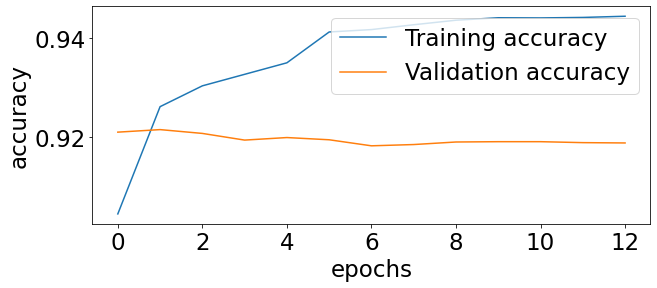

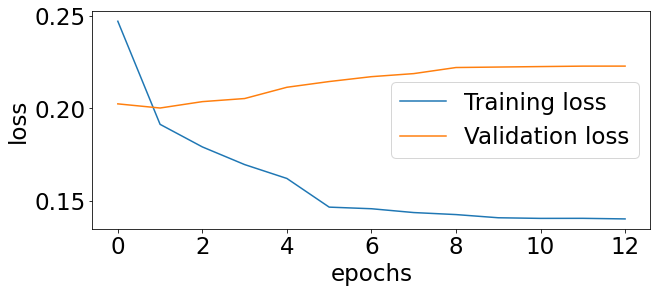

607/607 [==============================] - 3s 4ms/step


 Classification Report for label 'Anomaly_Conflict': 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     15934
           1       0.81      0.71      0.76      3464

    accuracy                           0.92     19398
   macro avg       0.88      0.84      0.86     19398
weighted avg       0.92      0.92      0.92     19398


------- Execution finished for label 'Anomaly_Conflict' ! -------
--- It took 8.8 minutes --- 




In [22]:
# Test: Call the function on one anomaly label
training_history, metrics = word_embedding_clf(df['Narrative_PP_stemmed_str'], 
                                               df['Anomaly_Conflict'],
                                              ( maxlen = 200, 
                                               num_words = 3000, 
                                               N_emb = 200))

In [24]:
# /!\ takes time to run!
# Call the function looping on all anomalies
# list of metrics DataFrames of our experiment
metrics_df_list = []

for anomaly in Anomaly_RootLabels_columns:
  training_history, metrics = word_embedding_clf(df['Narrative_PP_stemmed_str'], df[anomaly])
  metrics_df_list.append(metrics)

metrics_exp = pd.concat(metrics_df_list)
# Reset index, otherwise you get a repetition of 0,1,2,3
metrics_exp = metrics_exp.reset_index().drop(columns =['index'])

TypeError: ignored

### Save the data externally

In [25]:
# # save the df externally
# ##########################################################
# # WARNING!! 
# # If you execute this cell, you will OVERWRITTE the data!
# ##########################################################

# %cd /content/drive/MyDrive/data/transformed/model_results/

# with open("metrics_WordEmbedding_20220727_1700.pkl", "wb") as f:
#     pkl.dump([metrics_exp], f) # saves the variables into a list

In [26]:
metrics_exp.head(3)

NameError: ignored

### Plot scores

In [ ]:
def plot_scores_bokeh(metrics_list, metrics_exp):

  # Select sub-DataFrame corresponding to a given metric
  for metric in ['precision', 'recall', 'f1-score', 'support']:
    sub_df = metrics_exp[metrics_exp['metric'] == metric]


    # Listes de données
    modalites = sub_df['anomaly'].unique().tolist()
    valeur1 = sub_df['0']                 # valeur 1 de chaque modalité
    valeur2 = sub_df['1']                 # valeur 2 de chaque modalité
    valeur3 = sub_df['macro avg']         # valeur 3 de chaque modalité

    source = ColumnDataSource({'x' : modalites, 
                              'valeur 1' : valeur1, 
                              'valeur 2' : valeur2, 
                              'valeur 3' : valeur3
                              })
    f = figure(title = f'{metric}',
               width = 800, height = 500, 
               x_range = modalites)
    f.title.text_font_size = '14pt'
    f.xaxis.major_label_orientation = math.pi/3

    #Créer les dictionnaires d'abscisses abscisses_1, abscisses_2 et abscisses_3 décalées respectivement de -0.25, 0 et 0.25. Chaque appel de cette fonction devra prendre en argument du paramètre range l'étendue de l'axe des abscisses de la figure instanciée précédemment et 'x' en argument du paramètre field_name. Ceci permettra à la méthode glyph de faire le lien entre la source et le décalage à appliquer.

    from bokeh.transform import dodge

    abcisses1 = dodge(field_name = 'x', value = -0.25, range = f.x_range)
    abcisses2 = dodge(field_name = 'x', value = 0, range = f.x_range)
    abcisses3 = dodge(field_name = 'x', value = 0.25, range = f.x_range)


    f.vbar(source = source, x = abcisses1, top = 'valeur 1', width = 0.2, color = '#16a3e0', legend_label = "0")
    f.vbar(source = source, x = abcisses2, top = 'valeur 2', width = 0.2, color = '#962c61', legend_label = "1")
    f.vbar(source = source, x = abcisses3, top = 'valeur 3', width = 0.2, color = '#33cccc', legend_label = "macro avg")

    f.legend.location ='top_right'
    show(f)

In [ ]:
# Call the plot function
metrics_list = ['precision', 'recall', 'f1-score', 'support']
plot_scores_bokeh(metrics_list, metrics_exp)

# Crosstab

In [ ]:
df[anomalies].head()

# Multiclass, multilabel classification with Word Embedding


In [ ]:
anomalies = [ 'Anomaly_Aircraft Equipment', 
              'Anomaly_Airspace Violation',
              'Anomaly_ATC Issue', 
              'Anomaly_Flight Deck / Cabin / Aircraft Event',
              'Anomaly_Conflict', 
              'Anomaly_Deviation - Altitude',
              'Anomaly_Deviation - Speed', 
              'Anomaly_Deviation - Track / Heading',
              'Anomaly_Deviation / Discrepancy - Procedural',
              'Anomaly_Ground Excursion', 
              'Anomaly_Ground Incursion',
              'Anomaly_Ground Event / Encounter',
              'Anomaly_Inflight Event / Encounter',
              'Anomaly_No Specific Anomaly Occurred']
# I got this list from df.columns
# 14 labels

In [ ]:
target = df[anomalies].values
print(target[7:10]) # There are indeed multiple labels for one narrative
print("Shape of target:", target.shape)

In [ ]:
# This should be converted into a class with its attributes and methods...
def word_embedding_multilabel_clf(data, target, maxlen, num_words, N_emb, num_classes, training = True, epochs = 50): 
  """
  Perform multiclass, MULTILABEL classification using WordEmbedding

  Inputs:
  - data as pd.Series, narrative strings, e.g. df['Narrative_PP_stemmed_str']
  
  - target as ndarray, shape = (#samples, #classes) containing 0's and 1's
    A sample may contain several 1's (multilabel context)
  
  - maxlen (int) : length of the text vector (in words). Will ignore narrative content beyond this limit
  
  - num_words (int): desired vocab size; only the most common words are kept
  
  - N_emb (int) = 200: Dimension of embedding (# columns of the embedding matrix)

  - num_classes: number of classes, used in the last Dense() layer

  - training (bool): train or load model from file

  - epochs: # of epochs to train


  Returns:
  - y_pred_proba: The multilabel predictions of our model, i.e. ndarray
  of shape (#samples, #classes) containing probabilities to belong to each class,
  For a given sample, the sum of probabilities may exceed 1 (multilabel context)

  - y_test for performance evaluation outside this function 
   
  - model for saving it
  """ 

  # Time the function execution
  start_time = time.time()
  print(7*'-', f"Execution started...", 7*'-')

  # Train-test split  
  X_text_train, X_text_test, y_train, y_test = train_test_split(data, target, 
                                                      test_size= 0.2,
                                                      random_state = 12) 

  ###############################
  # TOKENIZE
  from tensorflow.keras.preprocessing.text import Tokenizer

  tokenizer = Tokenizer(num_words = num_words, # only the most common words are kept
                        oov_token = 'OOV'
                        ) 
  tokenizer.fit_on_texts(X_text_train) # Updates internal vocabulary based on a list of texts

  # Save the dictionary of correspondence between words and indices
  word2idx = tokenizer.word_index
  # Save the dictionary of correspondence between indices and words
  idx2word = tokenizer.index_word
  # Save the vocab size
  vocab_size = tokenizer.num_words  
  print('Tokenization completed.')
  print(f'Vocabulary size: {vocab_size} (user-defined)\n')
  example_OOV = word2idx['OOV']
  print(f"Example: index of 'OOV': {example_OOV} (Out-Of-Vocabulary label; user-defined)")
  example_aircraft = word2idx['aircraft']
  print(f"Example: index of 'aircraft': {example_aircraft}\n")
  print(30*"-")

  ###############################
  # VECTORIZE NARRATIVES
  # Map each text into a sequence of integers (word indices)
  # We use the vocab obtained from training on the X_text_train data to vectorize both the train and test data
  # Transform every review into a sequence of integers (indices of the vocab)
  X_train = tokenizer.texts_to_sequences(X_text_train)
  X_test = tokenizer.texts_to_sequences(X_text_test)
  print('Vectorization completed.')
  rnd_idx = np.random.randint(len(X_train), size = 2)
  for idx in rnd_idx:
    print(f'Random examples of entries in X_train:\n {X_train[idx]}')
    print(f'Length: {len(X_train[idx])}\n')
  print(30*"-")

  # Pad & truncate train and test sequences (texts transformed in numeric sequences) to make them of the same length
  X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, # Liste des textes transformés en index
                                                          maxlen = maxlen, # Nombre maximal de mots dans un texte. See length analysis above
                                                          padding = 'post', # pad either before or after each sequence
                                                          truncating = 'post', # truncate either before or after each sequence
                                                          value=0.0) # with what to pad
  # if maxlen is not provided, uses the length of the longest sequence in the list.
  X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen = maxlen, padding = 'post', truncating= 'post')
  print('Sequence padding / truncating completed.\n')
  print(f'Each entry in X_train has length: {maxlen} (user-defined)\n')

  for idx in rnd_idx:
    print(f"Entries in X_train now look like this (observe the presence of '1', corresponding to 'OOV'):\n\n {X_train[idx]}\n")
  print(30*"-")  

  if training == True:
    ###############################
    # BUILD THE MODEL
    tf.keras.backend.clear_session()
    # Keras starts with a blank state at each iteration and memory consumption is constant over time.

    model = Sequential(name = "Word_Embedding_model_MULTILABEL_classification") # does not accept spaces
    model.add(Embedding(input_dim = vocab_size, output_dim = N_emb)) # The embedding matrix is a *trainable* parameter
    model.add(GlobalAveragePooling1D()) # no parameters to tune; it's an advantage of GlobalAveragePooling1D
    # Use global average pooling blocks as an alternative to a Flatten() layer 

    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dropout(rate = 0.3)) # prevents overfitting
    model.add(Dense(units = num_classes, activation = 'sigmoid')) # num_classes units, because we have a multiclass (and multilabel) classification problem
    # 'sigmoid' activation because multilabel classification (DO NOT USE softmax, since the classes are not mutualy exclusive)
    print(model.summary())

    ###############################   
    # Define CALLBACKS
    TON = callbacks.TerminateOnNaN() # Callback that terminates training when a NaN loss is encountered

    early_stopping = callbacks.EarlyStopping(monitor = 'binary_accuracy', # 'binary_accuracy' calculates how often predictions match binary labels.
                                            min_delta=0.01,
                                            patience = 7, 
                                            mode = 'max', 
                                            restore_best_weights = True, 
                                            verbose = 1)

    lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'binary_accuracy',
                                            patience = 3, 
                                            verbose = 1, # nombre d'informations qui seront affichées durant l'apprentissage
                                            min_delta=0.01,
                                            mode = 'max')
    ###############################
    # Compile and FIT the model
    opt = keras.optimizers.Adam(#learning_rate = 0.0001 # default learning_rate = 0.001
                                ) 
    model.compile(optimizer = opt, 
                  loss = 'binary_crossentropy', # penalize each output node independently; pick a binary loss and model the output of the network as a independent Bernoulli (sigmoid) distributions per label.
                  metrics = ['accuracy', 'binary_accuracy', 'binary_crossentropy']) # see https://keras.io/api/metrics/

    training_history = model.fit(
              X_train, y_train,
              validation_split = 0.2,
              epochs = epochs, # can be high number; callbacks will stop it earlier anyway
              batch_size = 32, # the higher, the faster one epoch is completed
              callbacks = [TON, early_stopping, lr_plateau
                            ],
              verbose = True)

    ###############################
    # Plot the train history
    plot_train_history(training_history, 'accuracy', '') # '' instead of anomaly_name
    plot_train_history(training_history, 'loss', '')

  if training == False:  # model = loaded model
    %cd /content/drive/MyDrive/data/saved models/Yannis/2022_08_07_WordEmbedding_Multilabel/
    filename = '2022_08_07_WordEmbedding_Multilabel.pkl'
    model = pkl.load(open(filename, 'rb'))

  ###############################
  # EVALUATE
  # The multilabel predictions of our model (probabilities, whose sum may exceed 1 for a given sample)
  y_pred_proba = model.predict(X_test, batch_size=32, verbose=1) 

  # Calculate and print time to execute
  print(7*'-', f"Execution finished!", 7*'-')
  end_time = time.time()
  print(f"--- It took {np.round((end_time - start_time)/60,1)} minutes --- \n\n")

  return y_pred_proba, y_test, model

In [ ]:
# Join all tokens into a single string
df['Narrative_PP_stemmed_str'] = df['Narrative_PP_stemmed'].apply(lambda token_list: ' '.join(entry for entry in token_list))

In [ ]:
# call the function (decide whether to train or not!)
y_pred_proba, y_test, model = word_embedding_multilabel_clf(data = df['Narrative_PP_stemmed_str'],
                                             epochs = 50,
                                             target = target, 
                                             maxlen = 200, 
                                             num_words = 3000, 
                                             N_emb = 200, 
                                             num_classes = 14,
                                             training = False)

#### Save the model

In [ ]:
# # Save the model
# # The file takes some time to appear on the Drive
# %cd /content/drive/MyDrive/data/saved models/Yannis/2022_08_07_WordEmbedding_Multilabel/

# filename = '2022_08_07_WordEmbedding_Multilabel.pkl'
# pkl.dump(model, open(filename, 'wb'))

### Evaluate - MULTILABEL context

#### Define a threshold

**We define a THRESHOLD. Later we will plot an ROC curve to determine the optimum threshold (probably different for each label)**

In [ ]:
def y_prob_to_y_pred_ML(y_pred_proba, threshold = 0.5):
  """
  Converts probabilities into 0's and 1's. We are still in the MULTILABEL context.
  Input: MULTILABEL predictions (probabilities whose sum for each sample may exceed > 1) coming directly from the model
  Using a user-defined threshold, return a MULTILABEL prediction vector 'y_pred' containing 0's and 1's
  """
  y_pred=[]
  for sample in y_pred_proba:
    y_pred.append([1 if i>= threshold else 0 for i in sample])
  y_pred = np.array(y_pred)

  return y_pred

In [ ]:
y_pred = y_prob_to_y_pred_ML(y_pred_proba, threshold = 0.5) # call the function

#### Classification report

In [ ]:
print(f"\n\n Classification Report: \n {classification_report(y_test, y_pred, target_names = anomalies)}\n")



 Classification Report: 
                                               precision    recall  f1-score   support

                  Anomaly_Aircraft Equipment       0.88      0.83      0.86      7666
                  Anomaly_Airspace Violation       0.79      0.34      0.48       804
                           Anomaly_ATC Issue       0.81      0.44      0.57      3165
Anomaly_Flight Deck / Cabin / Aircraft Event       0.85      0.57      0.68      1515
                            Anomaly_Conflict       0.84      0.69      0.76      3464
                Anomaly_Deviation - Altitude       0.81      0.47      0.59      1732
                   Anomaly_Deviation - Speed       0.61      0.08      0.14       525
         Anomaly_Deviation - Track / Heading       0.80      0.43      0.56      1610
Anomaly_Deviation / Discrepancy - Procedural       0.77      0.85      0.81     11651
                    Anomaly_Ground Excursion       0.74      0.41      0.52       437
                    Anoma

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Note how the 'support' is much higher than len(y_test) due to the multilabels.

In [ ]:
len(y_test)

19398

In [ ]:
metrics.accuracy_score(y_test, y_pred)
# accuracy evaluates whether all the 14-class predictions are correct or not; it is not label-based

0.3848850396948139

In [ ]:
metrics.precision_score(y_test, y_pred, average = None)
# This is the same as the 1st column of the classification report
# The options average = 'micro', average = 'macro' return the 'micro avg' and 'macro avg' for precision, like in the classification report

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.88107364, 0.78735632, 0.80932945, 0.84920635, 0.83619783,
       0.80919081, 0.6119403 , 0.79839633, 0.77257107, 0.74058577,
       0.75149343, 0.71736663, 0.77891424, 0.        ])

#### Multilabel Confusion matrix

In [ ]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[10868,   864],
        [ 1265,  6401]],

       [[18520,    74],
        [  530,   274]],

       [[15906,   327],
        [ 1777,  1388]],

       [[17731,   152],
        [  659,   856]],

       [[15467,   467],
        [ 1080,  2384]],

       [[17475,   191],
        [  922,   810]],

       [[18847,    26],
        [  484,    41]],

       [[17612,   176],
        [  913,   697]],

       [[ 4835,  2912],
        [ 1759,  9892]],

       [[18899,    62],
        [  260,   177]],

       [[18114,   208],
        [  447,   629]],

       [[17665,   249],
        [  852,   632]],

       [[15401,   562],
        [ 1455,  1980]],

       [[19273,     0],
        [  125,     0]]])

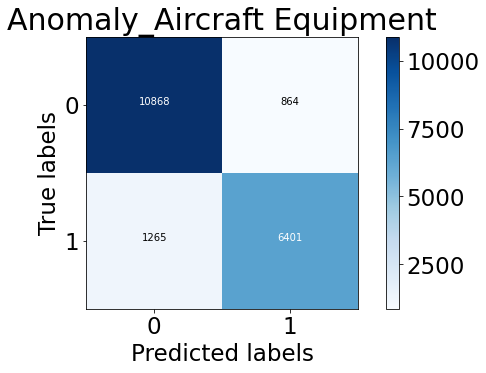

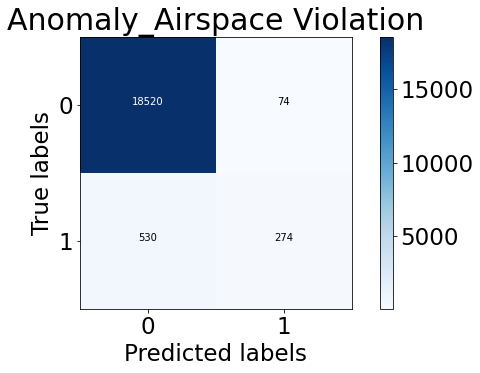

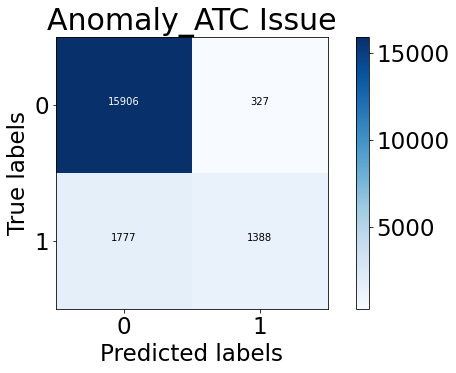

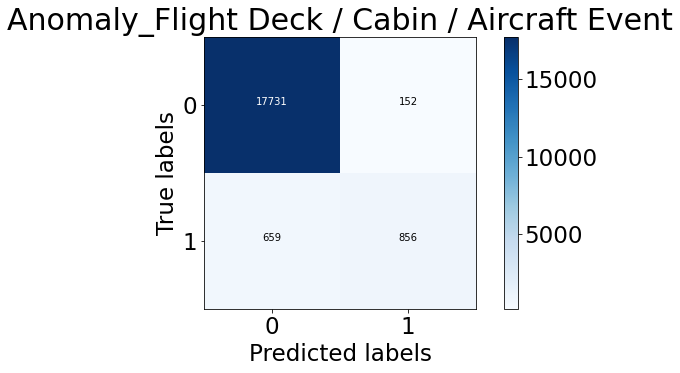

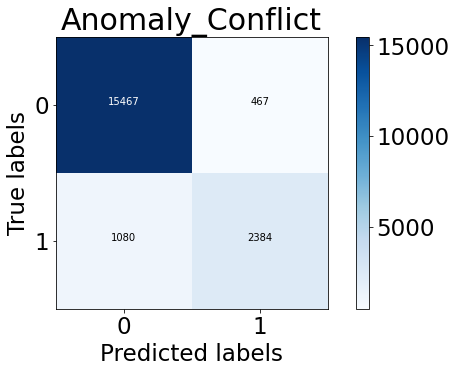

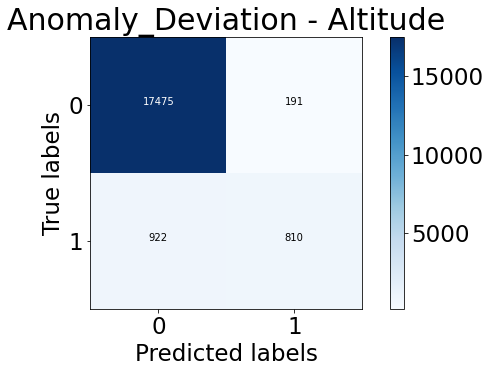

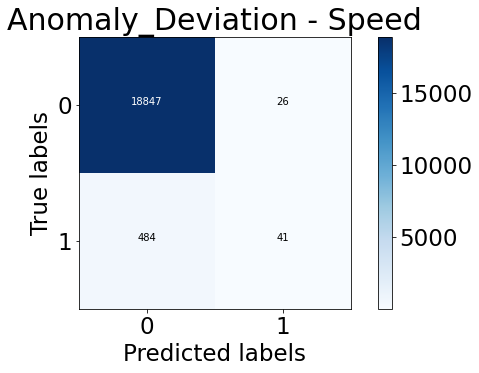

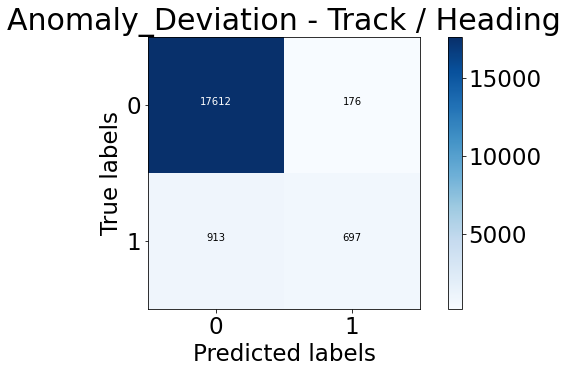

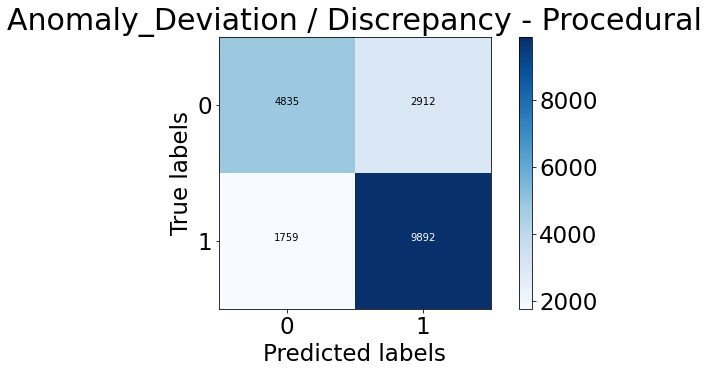

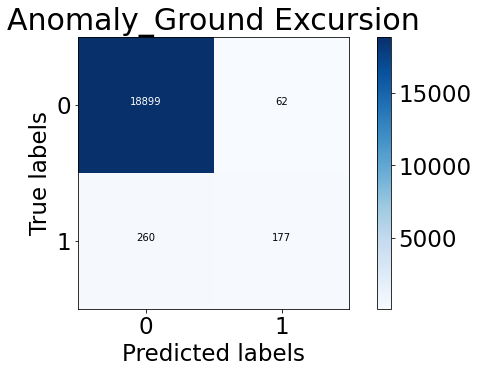

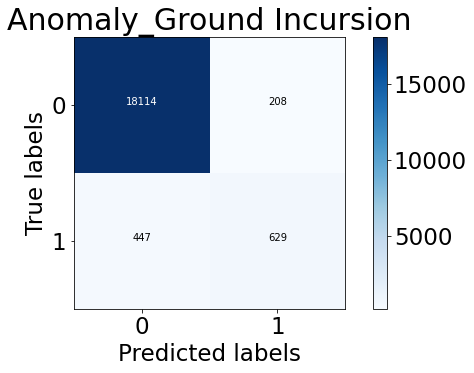

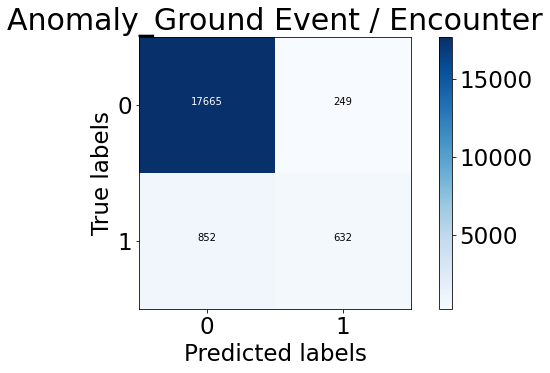

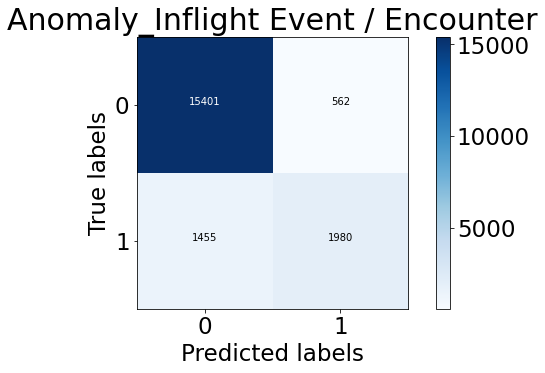

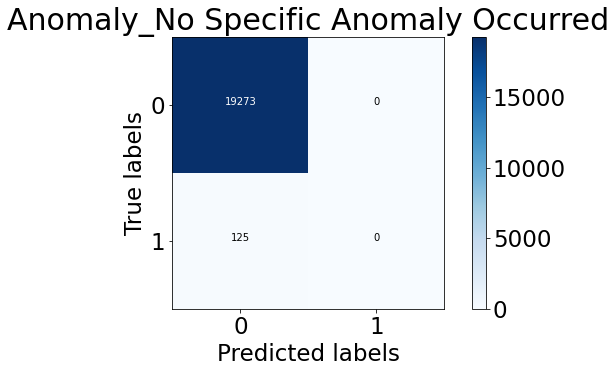

In [ ]:
# Confusion matrix for each label
mult_lbl_conf_mat = multilabel_confusion_matrix(y_test, y_pred)
classes = [0,1]
labels = anomalies

for i in range(mult_lbl_conf_mat.shape[0]): # iterate through the amount of classes
  cnf_matrix = mult_lbl_conf_mat[i]

  plt.figure(figsize = (10,5))
  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
  plt.title(f"{labels[i]}")
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, cnf_matrix[i, j],
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('True labels')
  plt.xlabel('Predicted labels')
  plt.show()

### Evaluate - BINARY context

#### ROC curve

Receiver Operating Curve

Objective: find the optimal decision threshold.

A good model should always have area greater than the area given by Red line. It should never be less than 0.5; as this would mean that a random classifier performs better than our model!


##### ROC for 1 label

In [ ]:
def y_multilabel_to_binary(y_test, y_pred_proba, cls_idx):
  """
  For a given class with index 'cls_idx', convert true labels and predicted 
  probabilities from multilabel to binary classification format.
  Used to plot Receiver-Operating Curves (ROCs)

  Inputs:
  - y_test: ndarray, shape (#samples, # classes) containing 0 or 1, e.g. array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
    Each row may contain several '1' (multilabel)
  - y_pred_proba: ndarray, shape (#samples, # classes) containing probabilities for each class, as return from our model. 
    The probabilities for a given sample may sum to >1 in multilabel problems.
  - cls_idx: class index (int). Pick the class of interest.

  Return
  - y_test_cls: true labels for the given class
  - probs_cls: probabilities for the given class
  """
  # Initialize variables
  y_test_cls = []
  probs_cls = []

  for i in range(len(y_test)): # Loop through the input test-set
    # Pick the values corresponding to the class of interest
    y_test_cls.append(y_test[i][cls_idx])
    probs_cls.append(y_pred_proba[i][cls_idx])

  y_test_cls = np.array(y_test_cls)
  probs_cls = np.array(probs_cls)

  return y_test_cls, probs_cls

In [ ]:
# call the function for class 0
y_test_cls, probs_cls = y_multilabel_to_binary(y_test, y_pred_proba, cls_idx = 0)

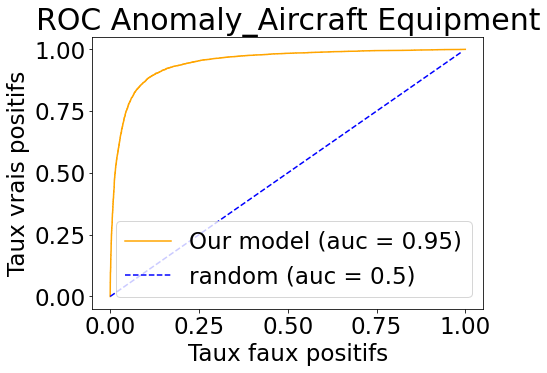

In [ ]:
# Plot ROC curve for cls_idx = 0
cls_idx = 0
fpr, tpr, seuils = roc_curve(y_test_cls, probs_cls, pos_label = 1)

roc_auc = metrics.auc(fpr, tpr)
roc_auc
# Plot ROC using MATPLOTLIB
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize = (7,5))
plt.plot(fpr, tpr, color = 'orange', label = 'Our model (auc = %0.2f)' % roc_auc)
plt.plot(np.arange(0,1,0.01), np.arange(0,1,0.01), '--b', label = 'random (auc = 0.5)')

plt.title(f'ROC {anomalies[cls_idx]}')
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')

plt.legend(loc = 'lower right');

###### Determine the optimal threshold using ROC

* The choice of a threshold depends on the importance of TPR and FPR classification problem. For example, if your classifier will decide which criminal suspects will receive a death sentence, false positives are very bad (innocents will be killed!). Thus you would choose a threshold that yields a low FPR while keeping a reasonable TPR (so you actually catch some true criminals). If there is no external concern about low TPR or high FPR, one option is to weight them equally by choosing the threshold that maximizes 𝑇𝑃𝑅−𝐹𝑃𝑅.

* Choose the point closest to the top left corner of your ROC space. Now the threshold used to generate this point should be the optimal one.

Implementation ideas:
*   We can use a BOKEH figure with a Hovertool
*   Pick the threshold 𝑡 that minimizes the distance to the top left can be done by measuring its distance

In [ ]:
def find_opt_threshold_ROC(fpr, tpr, seuils):
  """
  Find the optimal threshold in a given Receiver-Operating Curve (ROC) 
  by determining the threshold that yields the min distance to the top-left 
  of the ROC.

  Returns the threshold value
  """
  dist = [] # distance from the point (fpr = 0; tpr = 1)
  for f, t in zip(fpr, tpr):
    dist.append(np.sqrt( (1 - t)**2 + f**2 ))

  dist = np.array(dist)

  # Find the threshold yielding the min distance
  min_dist_idx = np.argmin(dist)
  min_dist = dist[min_dist_idx]
  optimum_threshold = seuils[min_dist_idx]
  
  return optimum_threshold

In [ ]:
find_opt_threshold_ROC(fpr, tpr, seuils)

0.36998737

###### Plot multiple anomalies

In [ ]:
def get_ROC_AUC(y_test, y_pred_proba, cls_idx):
  """
  For a fiven class index 'cls_idx' calculate ROC, AUC
  Inputs: MULTILABEL true labels and probabilities, like inputs of y_multilabel_to_binary()
  Return: fpr, tpr, seuils, roc_auc 
  The use of this function is mainly for determining the optimal threshold for each class.
  """
  y_test_cls, probs_cls = y_multilabel_to_binary(y_test, y_pred_proba, cls_idx)

  # Calculate ROC & AUC
  fpr, tpr, seuils = roc_curve(y_test_cls, probs_cls, pos_label = 1)
  roc_auc = metrics.auc(fpr, tpr)

  return fpr, tpr, seuils, roc_auc

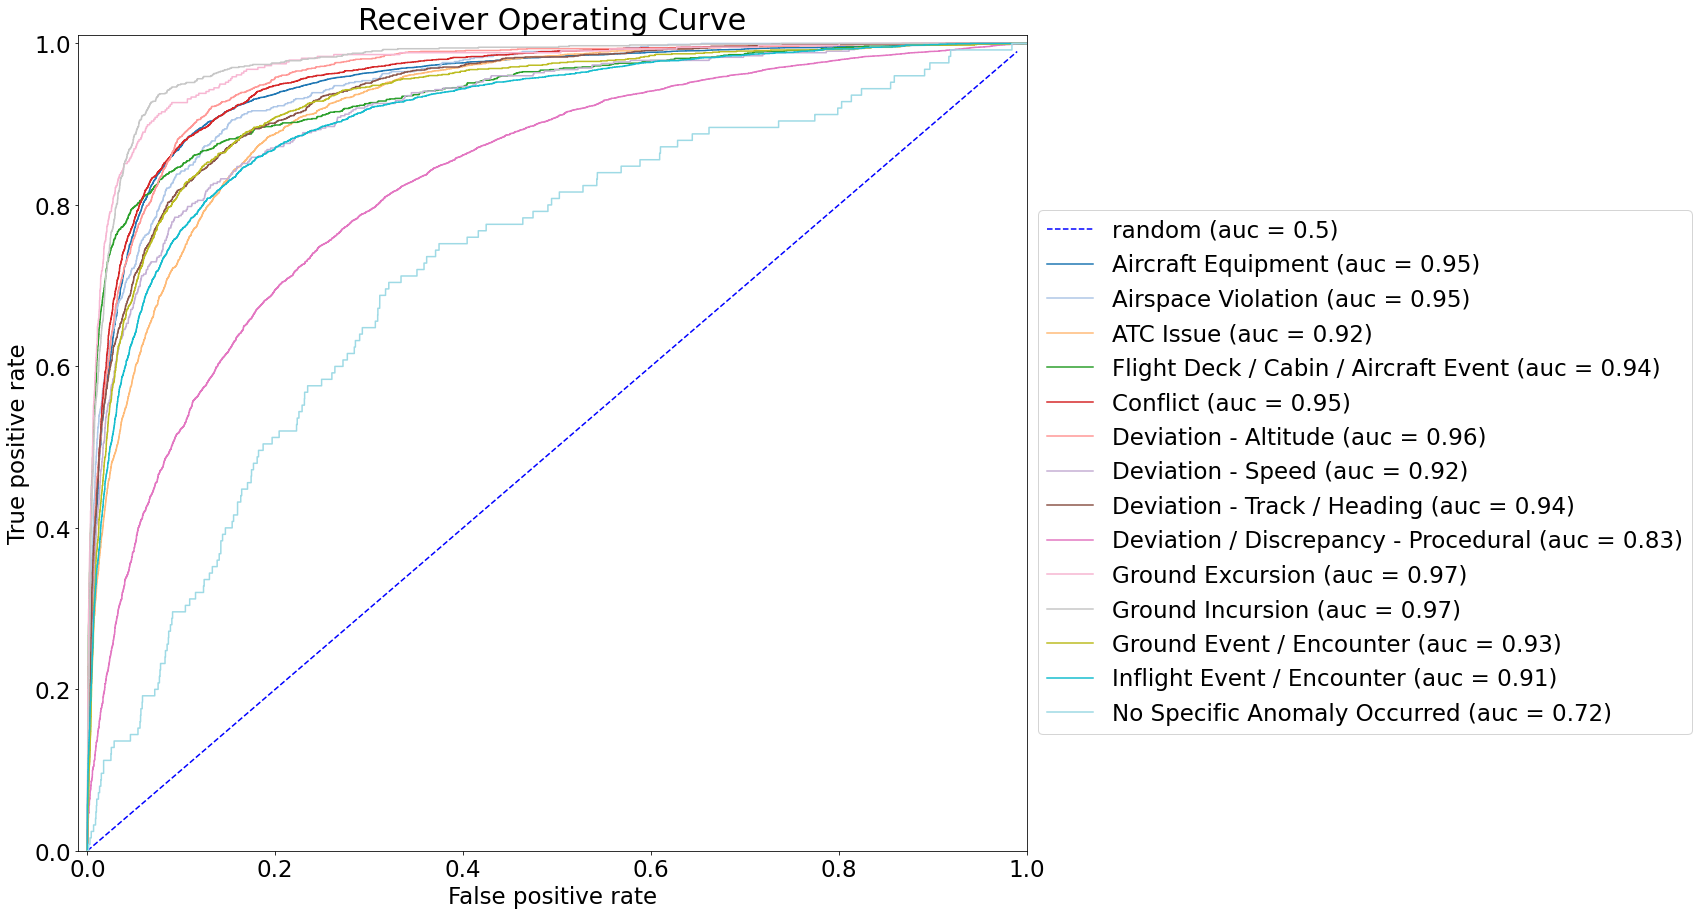

In [ ]:
fig = plt.figure(figsize = (17,15))

# Plot random classifier curve
plt.plot(np.arange(0,1,0.01), np.arange(0,1,0.01), '--b', label = 'random (auc = 0.5)')

# Create a colormap
num_classes = len(anomalies)
def get_cmap(n, name='tab20'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
cmap = get_cmap(num_classes)

# Iterate through classes and add corresponding ROC to the plot
for cls_idx in range(len(anomalies)):
  
  # Calculate fpr, tpr, seuils, roc_auc
  fpr, tpr, seuils, roc_auc = get_ROC_AUC(y_test, y_pred_proba, cls_idx)
  # Plot
  plt.plot(fpr, tpr, c = cmap(cls_idx), label = f'{anomalies[cls_idx][8:]} (auc = %0.2f)' % roc_auc)

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.title('Receiver Operating Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(bbox_to_anchor=(1, 0.8)); # move legend outside the plot

###### Determine the optimal threshold for each anomaly

In [ ]:
# Iterate through classes and find the optimal threshold
opt_thresholds = []

for cls_idx in range(len(anomalies)):
  
  # Calculate fpr, tpr, seuils, roc_auc
  fpr, tpr, seuils, roc_auc = get_ROC_AUC(y_test, y_pred_proba, cls_idx)
  
  # Get optimal thresholds
  opt_thresholds.append(find_opt_threshold_ROC(fpr, tpr, seuils))

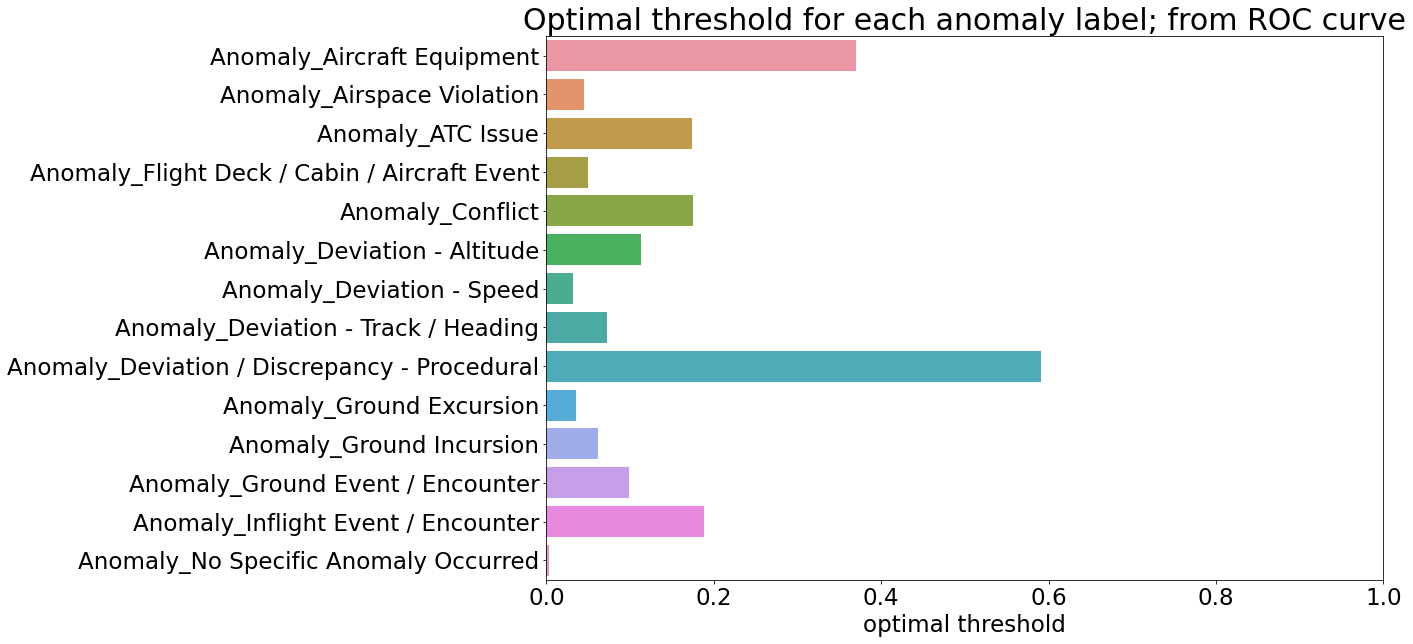

In [ ]:
fig = plt.figure(figsize = (15,10))
sns.barplot(x = opt_thresholds, y = anomalies)

plt.xlabel('optimal threshold')
plt.xlim([0,1])
plt.title('Optimal threshold for each anomaly label; from ROC curve');

##### Evaluate using anomaly-specific thresholds as determined from ROC 

In [ ]:
def y_prob_to_y_pred(y_pred_proba, threshold = 0.5):
  """
  Converts probabilities into 0's and 1's. We are still in the BINARY context.
  Input: monolabel predictions (probabilities), dimension = #samples
  Using a user-defined threshold, return a prediction vector 'y_pred' with 
  dimension = #samples, containing a '0' or a '1' for each sample
  """
  y_pred=[]
  for value in y_pred_proba:

    if value >= threshold:
      y_pred.append(1)
    else :
      y_pred.append(0)

  y_pred = np.array(y_pred)

  return y_pred

In [ ]:
for anomaly, threshold, cls_idx in zip(anomalies, opt_thresholds, range(len(anomalies))):

  # Exctract the labels for the class of interest
  y_test_cls, probs_cls = y_multilabel_to_binary(y_test, y_pred_proba, cls_idx)

  # Convert the MULTILABEL probabilities into 0's and 1's, using the optimal threshold for each anomaly
  y_pred = y_prob_to_y_pred(probs_cls, threshold = threshold)
  thres_round = str(np.round_(threshold, 2))

  print(f"\n\n Classification Report for {anomaly}, \n using threshold = {thres_round}: \n\n", classification_report(y_test_cls, y_pred), "\n")



 Classification Report for Anomaly_Aircraft Equipment, 
 using threshold = 0.37: 

               precision    recall  f1-score   support

           0       0.92      0.89      0.91     11732
           1       0.84      0.88      0.86      7666

    accuracy                           0.89     19398
   macro avg       0.88      0.89      0.89     19398
weighted avg       0.89      0.89      0.89     19398
 



 Classification Report for Anomaly_Airspace Violation, 
 using threshold = 0.05: 

               precision    recall  f1-score   support

           0       0.99      0.88      0.93     18594
           1       0.23      0.87      0.37       804

    accuracy                           0.88     19398
   macro avg       0.61      0.87      0.65     19398
weighted avg       0.96      0.88      0.91     19398
 



 Classification Report for Anomaly_ATC Issue, 
 using threshold = 0.17: 

               precision    recall  f1-score   support

           0       0.97      0.84     

#### Precision-Recall (PR) curve

Plot precision-recall curve that is suitable for IMBALANCED datasets

see https://www.kaggle.com/code/kmkarakaya/multi-label-model-evaluation/notebook

The precision-recall curve shows the tradeoff between precision and recall for different threshold.

Some reminders:

* A high area under the curve represents both high recall and high precision.

* A high precision relates to a low false positive rate

* A high recall relates to a low false negative rate.

* High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

* A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels.

* A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels.

* An ideal system with high precision and high recall will return many results, with all results labeled correctly.

* The relationship between recall and precision can be observed in the stairstep area of the plot - at the edges of these steps a small change in the threshold considerably reduces precision, with only a minor gain in recall.



##### Avg. precision score (AP)

[sklean-documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html): AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:

\begin{align}
        \text{AP} = \sum_n (R_n - R_{n-1}) P_n
    \end{align}

where $P_n $ and $R_n$ are the precision and recall at the $n$th threshold.

This implementation is not interpolated and is different from computing the area under the precision-recall curve with the trapezoidal rule, which uses linear interpolation and can be too optimistic.

In [ ]:
for anomaly, cls_idx in zip(anomalies, range(len(anomalies))):

  # Exctract the labels for the class of interest
  y_test_cls, probs_cls = y_multilabel_to_binary(y_test, y_pred_proba, cls_idx)

  average_precision = average_precision_score(y_test_cls, probs_cls)

  print(f"AP for {anomaly}:")
  print('{0:0.2f} \n'.format(average_precision))

AP for Anomaly_Aircraft Equipment:
0.92 

AP for Anomaly_Airspace Violation:
0.59 

AP for Anomaly_ATC Issue:
0.72 

AP for Anomaly_Flight Deck / Cabin / Aircraft Event:
0.76 

AP for Anomaly_Conflict:
0.83 

AP for Anomaly_Deviation - Altitude:
0.73 

AP for Anomaly_Deviation - Speed:
0.40 

AP for Anomaly_Deviation - Track / Heading:
0.68 

AP for Anomaly_Deviation / Discrepancy - Procedural:
0.87 

AP for Anomaly_Ground Excursion:
0.63 

AP for Anomaly_Ground Incursion:
0.74 

AP for Anomaly_Ground Event / Encounter:
0.61 

AP for Anomaly_Inflight Event / Encounter:
0.75 

AP for Anomaly_No Specific Anomaly Occurred:
0.02 



##### PR-curve

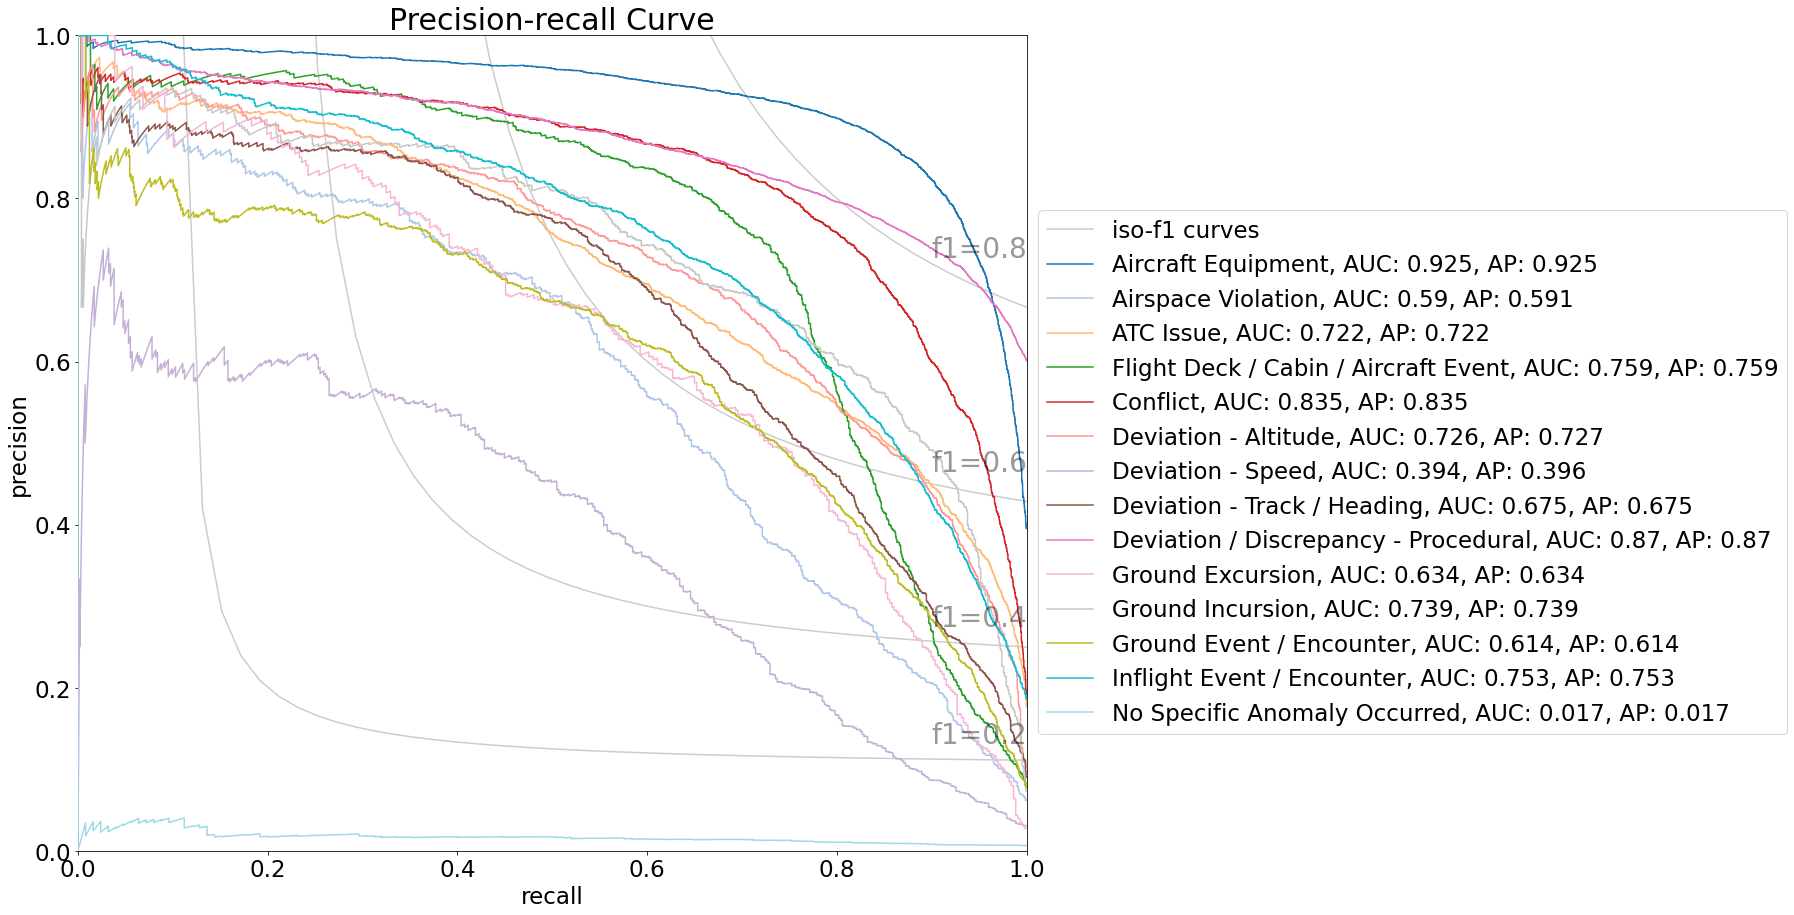

In [ ]:
fig = plt.figure(figsize = (17,15))

lines = []  # Instantiate list of plot lines (i.e. curves) 
labels = [] # Instantiate list of plot labels

###########################################################################
### PLOT iso-f1 lines #######
f_scores = np.linspace(0.2, 0.8, num=4)
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha = 0.4, zorder = 2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02), size=28, alpha = 0.4)

# Store in our lists for now, we call them later
lines.append(l)
labels.append('iso-f1 curves')


###########################################################################
### PLOT precision-recall lines #####
for anomaly, cls_idx in zip(anomalies, range(len(anomalies))):

  # Compute precision-recall pairs for different probability thresholds.
  y_test_cls, probs_cls = y_multilabel_to_binary(y_test, y_pred_proba, cls_idx)

  # Calculate precision, recall, thresholds
  precision, recall, thresholds = precision_recall_curve(y_test_cls, probs_cls)
 
  # calculate precision-recall AUC (Area Under Curve)
  auc = np.round(metrics.auc(recall, precision), 3)

  # calculate the average precision (AP)
  average_precision = average_precision_score(y_test_cls, probs_cls)
  average_precision = np.round(average_precision, 3)

  l, = plt.plot(recall, precision, c = cmap(cls_idx), zorder=3) # use the same cmap as in the ROC curve
  # ax.plot() returns a tuple which contains only one element. 
  # If you assign it without the comma, you just assign the tuple.
  # using the comma, you unpack the tuple and get its element

  lines.append(l)
  labels.append(f'{anomalies[cls_idx][8:]}, AUC: {auc}, AP: {average_precision}') # slice the string, to ommit 'Anomaly_'

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Precision-recall Curve')
plt.xlabel('recall')
plt.ylabel('precision')

plt.legend(lines, labels, bbox_to_anchor=(1, 0.8)); # here we use our lists of lines and labels

The difference between avg. precision (AP) and Area-Under-Curve (AUC) is not significant.

*How to interpret the curve?*
* Pick an anomaly and look at the 2 intersection points with one iso-f1 curve. These intersections give the recall and precision value pairs that yield the same f1-score. You can choose whether you want to favor the precision or the recall.

* The relationship between recall and precision can be observed in the stairstep area of the plot - at the edges of these steps a small change in the threshold considerably reduces precision, with only a minor gain in recall.

* see also the [scikit-learn documentation ](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py)

##### Determine the optimal threshold from PR curve

According to [this Kaggle nb](https://www.kaggle.com/code/nicholasgah/optimal-probability-thresholds-using-pr-curve):

There can be two ways of obtaining a more optimal probability threshold for the positive class:

* Minimize the difference between precision and recall scores. Select the probability threshold of which precision and recall scores are closest to each other


* The most optimal point on the PR curve should be (1,1), i.e. precision and recall scores of 1.
Select the probability threshold as the most optimal one if precision and recall scores are closest fo the ones mentioned in the previous point in terms of Euclidean distance



We implement the 2nd approach, which is similar to the way we determined optimal thresholds from the ROC.

In [ ]:
def find_opt_threshold_PR(precision, recall, thresholds):
  """
  Find the optimal threshold in a given Precision Recall (PR) Curve
  by determining the threshold that yields the min distance to the top-right
  point (1,1) of the PR curve.

  Returns the threshold value
  """
  dist = [] # distance from the point (precision = 1; recall = 1)
  for p, r in zip(precision, recall):
    dist.append(np.sqrt( (1 - p)**2 + (1 - r)**2 ))

  dist = np.array(dist)

  # Find the threshold yielding the min distance
  min_dist_idx = np.argmin(dist)
  min_dist = dist[min_dist_idx]
  optimum_threshold = thresholds[min_dist_idx]
  optimum_precision = precision[min_dist_idx]
  optimum_recall = recall[min_dist_idx]
  
  return optimum_threshold, optimum_precision, optimum_recall

In [ ]:
# Iterate through classes and find the optimal threshold and corresponding precision, recall
opt_thresholds = []
opt_precisions = []
opt_recalls = []

for anomaly, cls_idx in zip(anomalies, range(len(anomalies))):

  # Compute precision-recall pairs for different probability thresholds.
  y_test_cls, probs_cls = y_multilabel_to_binary(y_test, y_pred_proba, cls_idx)

  # Calculate precision, recall, thresholds
  precision, recall, thresholds = precision_recall_curve(y_test_cls, probs_cls)
  
  # Get optimal thresholds
  optimum_threshold, optimum_precision, optimum_recall = find_opt_threshold_PR(precision, recall, thresholds)
  
  opt_thresholds.append(optimum_threshold)
  opt_precisions.append(optimum_precision)
  opt_recalls.append(optimum_recall)

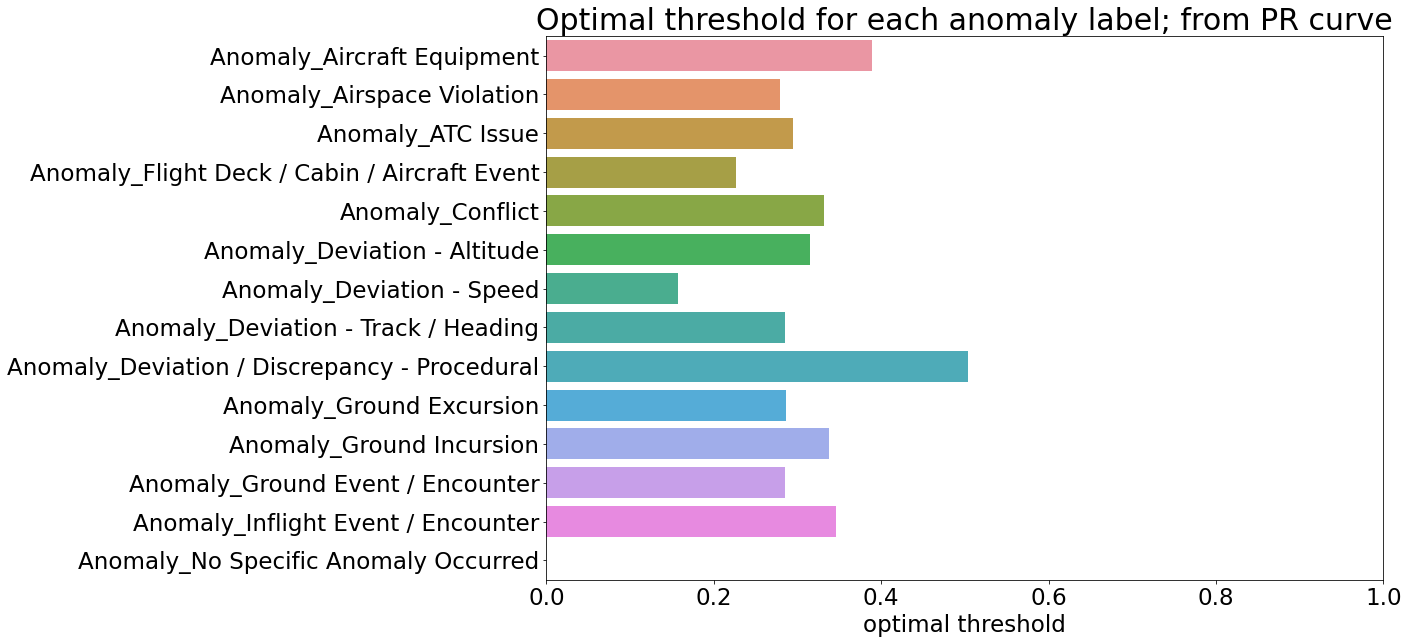

In [ ]:
fig = plt.figure(figsize = (15,10))
sns.barplot(x = opt_thresholds, y = anomalies)

plt.xlabel('optimal threshold')
plt.xlim([0,1])
plt.title('Optimal threshold for each anomaly label; from PR curve');

##### PR-curve with opt thresholds

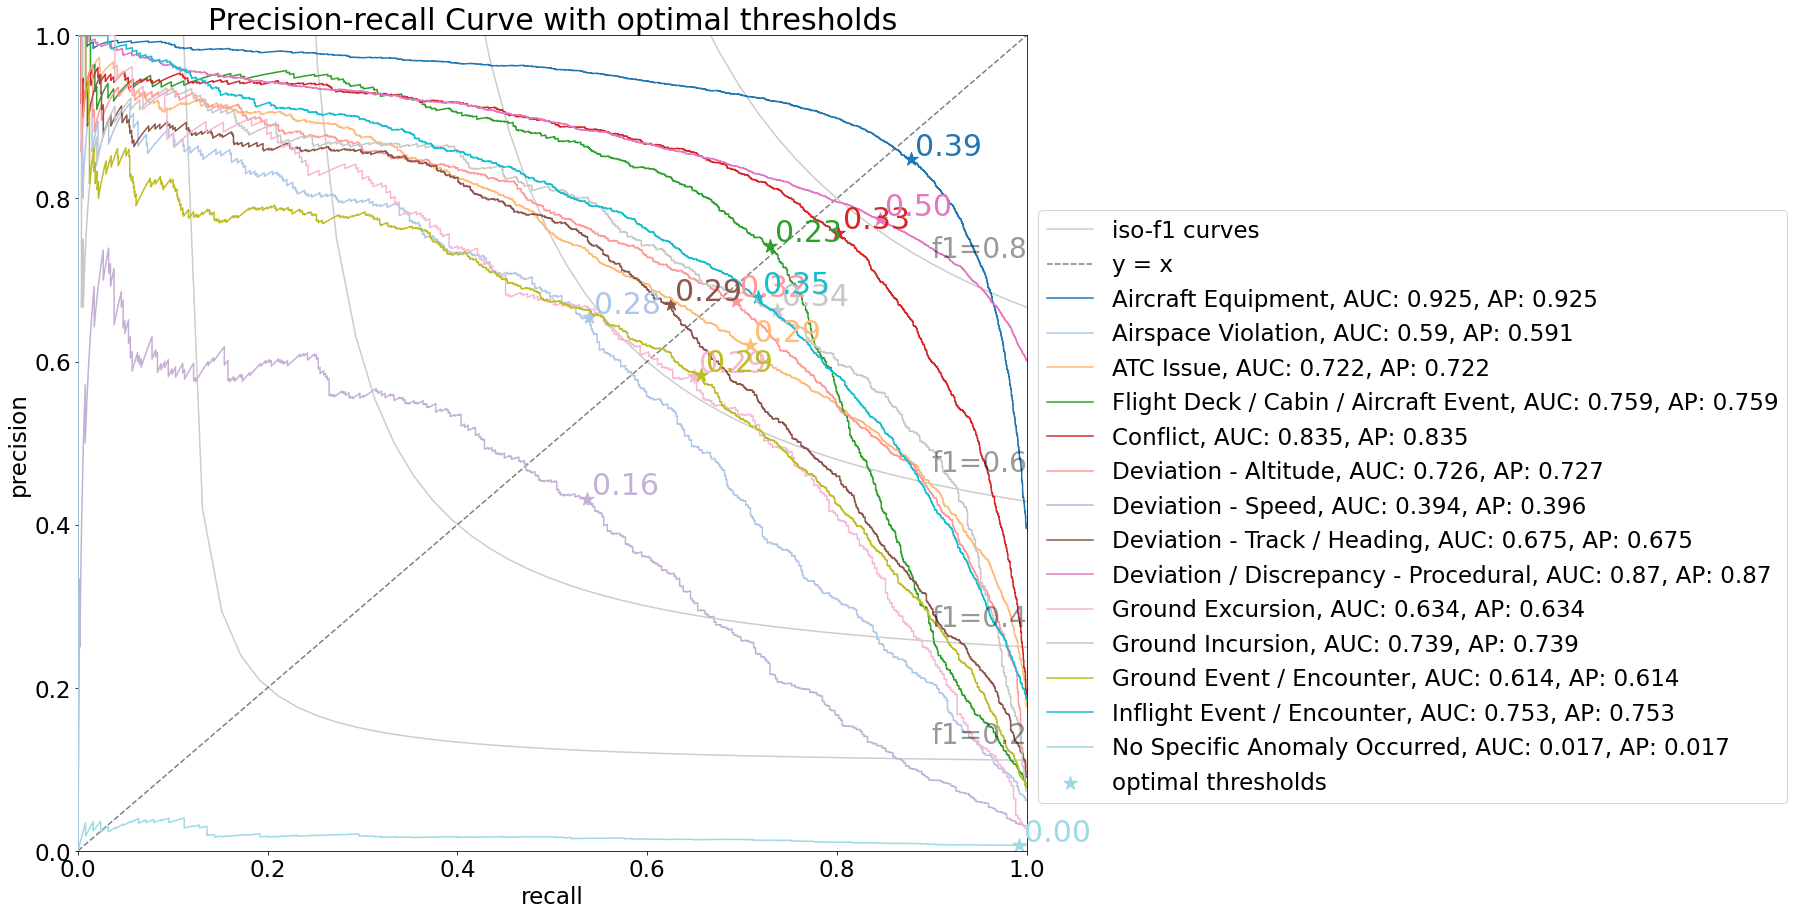

In [ ]:
fig = plt.figure(figsize = (17,15))

lines = []  # Instantiate list of plot lines (i.e. curves) 
labels = [] # Instantiate list of plot labels

###########################################################################
### PLOT iso-f1 lines #######
f_scores = np.linspace(0.2, 0.8, num=4)
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha = 0.4, zorder = 2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02), size=28, alpha = 0.4)

# Store in our lists for now, we call them later
lines.append(l)
labels.append('iso-f1 curves')

# Plot diagonal
l, = plt.plot([0,1], [0,1], '--k', alpha = 0.5)
lines.append(l)
labels.append('y = x')

###########################################################################
### PLOT precision-recall lines #####
for anomaly, cls_idx in zip(anomalies, range(len(anomalies))):

  # Compute precision-recall pairs for different probability thresholds.
  y_test_cls, probs_cls = y_multilabel_to_binary(y_test, y_pred_proba, cls_idx)

  # Calculate precision, recall, thresholds
  precision, recall, thresholds = precision_recall_curve(y_test_cls, probs_cls)
 
  # calculate precision-recall AUC (Area Under Curve)
  auc = np.round(metrics.auc(recall, precision), 3)

  # calculate the average precision (AP)
  average_precision = average_precision_score(y_test_cls, probs_cls)
  average_precision = np.round(average_precision, 3)

  color = cmap(cls_idx) # use the same cmap as in the ROC curve
  l, = plt.plot(recall, precision, c = color, zorder=3) 
  # ax.plot() returns a tuple which contains only one element. 
  # If you assign it without the comma, you just assign the tuple.
  # using the comma, you unpack the tuple and get its element

  lines.append(l)
  labels.append(f'{anomalies[cls_idx][8:]}, AUC: {auc}, AP: {average_precision}') # slice the string, to ommit 'Anomaly_'

  # Plot optimum thresholds
  x = opt_recalls[cls_idx]
  y = opt_precisions[cls_idx]
  s = plt.scatter(x, y, marker = '*', s = 200, color = color)

  plt.annotate('{0:0.2f}'.format(opt_thresholds[cls_idx]), xy = (x + 0.005, y + 0.005), color = color, size=30, alpha = 1)
  
lines.append(s)
labels.append('optimal thresholds')
  

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Precision-recall Curve with optimal thresholds')
plt.xlabel('recall')
plt.ylabel('precision')

plt.legend(lines, labels, bbox_to_anchor=(1, 0.8)); # here we use our lists of lines and labels

* The optimal thresholds vary significantly for each label. We attribute this to the imbalance of the labels

* We used the 'closest to point (1,1)' recipe to find the optimal thresholds. We plot the 'y = x' line to estimate how much this differs from the other recipe for fingind the optimal thresholds, i.e. 'precision and recall scores are closest to each other'. The variation does not look large; caution however, because the interpolation is **nonlinear**.

##### Evaluate using anomaly-specific thresholds as determined from PR curve

In [ ]:
for anomaly, threshold, cls_idx in zip(anomalies, opt_thresholds, range(len(anomalies))):

  # Exctract the labels for the class of interest
  y_test_cls, probs_cls = y_multilabel_to_binary(y_test, y_pred_proba, cls_idx)

  # Convert the MULTILABEL probabilities into 0's and 1's, using the optimal threshold for each anomaly
  y_pred = y_prob_to_y_pred(probs_cls, threshold = threshold)
  thres_round = str(np.round_(threshold, 2))

  print(f"\n\n Classification Report for {anomaly}, \n using threshold = {thres_round}: \n\n", classification_report(y_test_cls, y_pred), "\n")



 Classification Report for Anomaly_Aircraft Equipment, 
 using threshold = 0.39: 

               precision    recall  f1-score   support

           0       0.92      0.90      0.91     11732
           1       0.85      0.88      0.86      7666

    accuracy                           0.89     19398
   macro avg       0.88      0.89      0.89     19398
weighted avg       0.89      0.89      0.89     19398
 



 Classification Report for Anomaly_Airspace Violation, 
 using threshold = 0.28: 

               precision    recall  f1-score   support

           0       0.98      0.99      0.98     18594
           1       0.65      0.54      0.59       804

    accuracy                           0.97     19398
   macro avg       0.82      0.76      0.79     19398
weighted avg       0.97      0.97      0.97     19398
 



 Classification Report for Anomaly_ATC Issue, 
 using threshold = 0.29: 

               precision    recall  f1-score   support

           0       0.94      0.92     